In [13]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from facenet_pytorch import InceptionResnetV1

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

In [15]:
# Paths
data_dir = 'D:\\Images\\Training_images\\data'  # Labeled training data
output_dir = 'D:\\Images\\Covid\\output_images_detected'  # Unlabeled test data

Displaying one random image from Jonas Gahr Støre: Jonas Gahr Støre_37.jpg


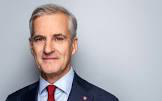

Displaying one random image from Erna Solberg: Erna Solberg_177.jpg


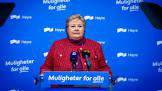

Displaying one random image from Bent Høie: Bent Høie_227.jpg


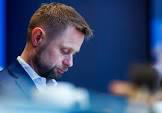

Displaying one random image from Lan Marie Berg: Lan Marie Berg_561.jpg


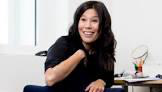

Displaying one random image from Sylvi Lysthaug: Sylvi Lysthaug_400.jpg


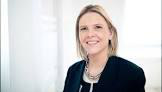

Displaying one random image from Espen Rostrup Nakstad: Espen Rostrup Nakstad_572.jpg


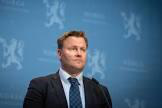

Displaying one random image from Trygve Slagsvold Vedum: Trygve Slagsvold Vedum_536.jpg


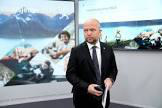

Displaying one random image from Camilla Stoltenberg: Camilla Stoltenberg_322.jpg


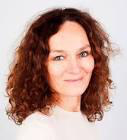

Displaying one random image from Fredrik Solvang: Fredrik Solvang_550.jpg


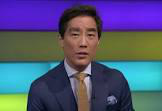

Displaying one random image from Donald Trump: Donald Trump_360.jpg


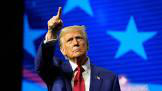

Displaying one random image from Joe Biden: Joe Biden_229.jpg


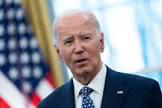

Displaying one random image from Anthony Fauci: Anthony Fauci_553.jpg


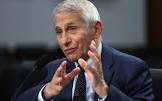

Displaying one random image from Bill Gates: Bill Gates_92.jpg


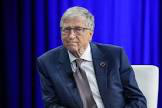

Displaying one random image from Random People Walking: Random People Walking_267.jpg


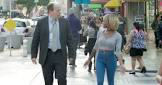

Displaying one random image from random people: random people_565.jpg


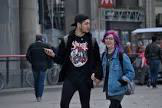

Displaying one random image from random facebook post: random facebook post_237.jpg


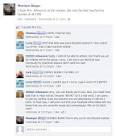

Displaying one random image from random twitter post: random twitter post_552.jpg


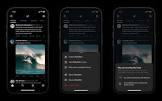

In [16]:
import random
from PIL import Image

subfolders = [f.name for f in os.scandir(data_dir) if f.is_dir()]

# Iterate over each subfolder (each species)
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)

    # Get a list of all image files in the subfolder
    images = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a random image from the subfolder
    random_image = random.choice(images)

    # Full path to the selected image
    image_path = os.path.join(subfolder_path, random_image)

    # Open and display the image<
    image = Image.open(image_path)
    print(f"Displaying one random image from {subfolder}: {random_image}")
    display(image)

In [17]:
class_names = [
    'Jonas Gahr Støre',
    'Erna Solberg', 
    'Bent Høie',
    'Lan Marie Berg',
    'Sylvi Lysthaug',
    'Espen Rostrup Nakstad',
    'Trygve Slagsvold Vedum',
    'Camilla Stoltenberg',
    'Fredrik Solvang',
    'Donald Trump',
    'Joe Biden',
    'Anthony Fauci',
    'Bill Gates',
    'Random People Walking',
    'random people',
    'random facebook post',
    'random twitter post'
]

In [18]:
transform = transforms.Compose([
    transforms.Resize((160,160)), # resize all images 
    transforms.RandomHorizontalFlip(), # randomly flip horizontally...
    transforms.RandomVerticalFlip(), # ... and vertically ...
    transforms.RandomRotation(30), # ... and rotate
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [19]:
# Load training data
train_data = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2) # Change if on GPU, batch=32

In [20]:
# Model: Pretrained FaceNet
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=len(class_names)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Using a scheduler to adjust the learning rate dynamically
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

Epoch [1/10], Loss: 2.2752
Epoch [2/10], Loss: 1.5329
Epoch [3/10], Loss: 0.9635
Epoch [4/10], Loss: 0.6286
Epoch [5/10], Loss: 0.4628
Epoch [6/10], Loss: 0.3608
Epoch [7/10], Loss: 0.2783
Epoch [8/10], Loss: 0.2333
Epoch [9/10], Loss: 0.2126
Epoch [10/10], Loss: 0.1968


In [21]:
from pathlib import Path

classified_dir = 'D:\\Images\\Covid\\classified_images'

for class_name in class_names:
    class_folder = Path(classified_dir) / class_name
    class_folder.mkdir(parents=True, exist_ok=True)

In [23]:
transform_inference = transforms.Compose([
    transforms.Resize((160,160)), # resize all images 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [22]:
import shutil

# Load unlabeled test images
test_images = [os.path.join(output_dir, img) for img in os.listdir(output_dir)]
model.eval()

def predict_image(image_path, model, transform_inference, class_names, classified_dir):
    image = Image.open(image_path).convert('RGB')
    image = transform_inference(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

    save_path = os.path.join(classified_dir, predicted_class, os.path.basename(image_path))
    shutil.copy(image_path, save_path)

for img_path in test_images:
    predict_image(img_path, model, transform_inference, class_names, classified_dir)

print("Classification complete!")

Classification complete!
